In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from vmdpy import VMD

In [3]:
# Load dataset
file_path = r"cleaned_data1.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found at: {file_path}")

df = pd.read_csv(file_path)

# Convert Date/Time to datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')
df.dropna(subset=['Date/Time'], inplace=True)

# Extract time features
df['hour'] = df['Date/Time'].dt.hour
df['day'] = df['Date/Time'].dt.day
df['month'] = df['Date/Time'].dt.month
df['weekday'] = df['Date/Time'].dt.weekday

# Define features and target
basic_features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'hour', 'day', 'month', 'weekday', 'Theoretical_Power_Curve (KWh)']
target = 'LV ActivePower (kW)'
missing_cols = [col for col in basic_features + [target] if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")
df.dropna(subset=basic_features + [target], inplace=True)

In [4]:
# Apply VMD to wind speed
def apply_vmd(signal, K=3, alpha=2000):
    tau = 0.         # noise-tolerance
    DC = 0
    init = 1
    tol = 1e-7
    u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)
    return u

vmd_modes = apply_vmd(df['Wind Speed (m/s)'].values, K=3)
for i in range(3):
    df[f'VMD_Mode_{i+1}'] = vmd_modes[i]

# 🔁 New feature set with VMD components
vmd_features = basic_features + ['VMD_Mode_1', 'VMD_Mode_2', 'VMD_Mode_3']
X = df[vmd_features]
y = df[target]

# Add Gaussian noise
def add_gaussian_noise(data, mean=0.0, std=0.01):
    noisy = data.copy()
    for col in ['Wind Speed (m/s)', 'Wind Direction (°)', 'Theoretical_Power_Curve (KWh)']:
        noise = np.random.normal(mean, std, size=noisy[col].shape)
        noisy[col] += noise
    return noisy

X_noisy = add_gaussian_noise(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [5]:
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

MSE : 0.0045
RMSE: 0.0674
MAE: 0.0280
R² Score: 0.9651


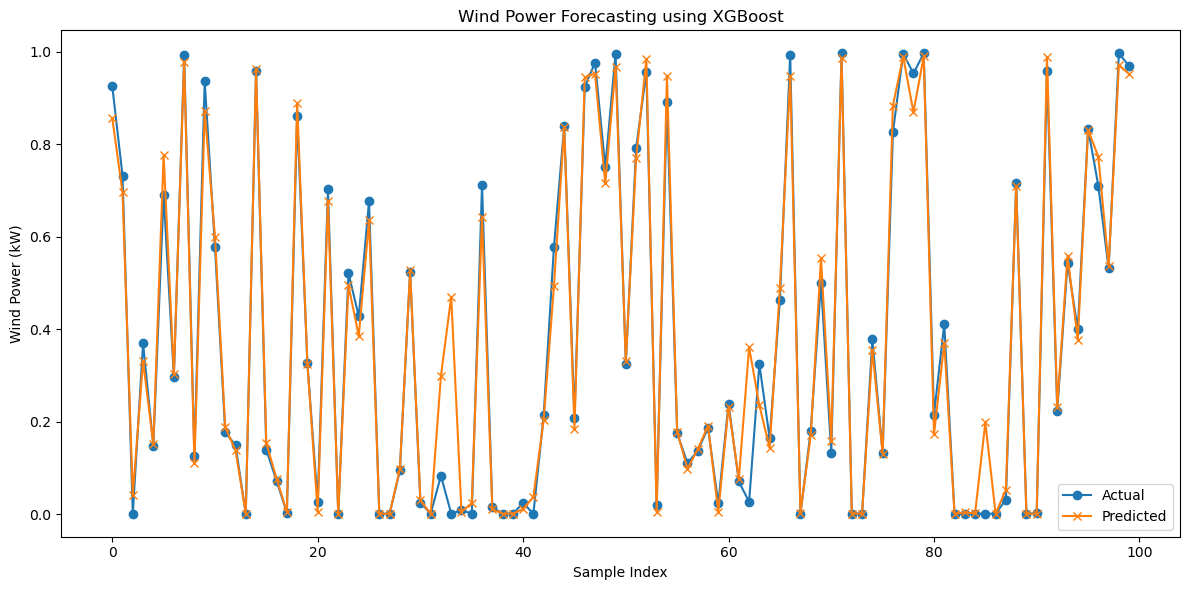

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_pred[:100], label='Predicted', marker='x')
plt.title('Wind Power Forecasting using XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Wind Power (kW)')
plt.legend()
plt.tight_layout()
plt.show()